In [1]:
import os
from functools import partial
from pathlib import Path
from typing import Tuple

import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from PIL import Image
import numpy as np


import cv2
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from scipy.stats import entropy
from tqdm import tqdm

import projects.common.constants as C

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


## Image dataset

In [2]:
print("The number of train images : \t", len(C.TRAIN_DATA_IMAGE))
print("The number of test images : \t",len(C.TEST_DATA_IMAGE))

The number of train images : 	 104875
The number of test images : 	 44946


# COCO API

In [3]:
coco=COCO(C.TRAIN_DATA_ANNOT)
print(coco)
"""
getAnnIds: Get ann ids that satisfy given filter conditions.
getCatIds: Get cat ids that satisfy given filter conditions.
getImgIds: Get img ids that satisfy given filter conditions.
loadAnns: Load anns with the specified ids.
loadCats: Load cats with the specified ids.
loadImgs: Load imgs with the specified ids.
showAnns: Display the specified annotations.
"""

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


'\ngetAnnIds: Get ann ids that satisfy given filter conditions.\ngetCatIds: Get cat ids that satisfy given filter conditions.\ngetImgIds: Get img ids that satisfy given filter conditions.\nloadAnns: Load anns with the specified ids.\nloadCats: Load cats with the specified ids.\nloadImgs: Load imgs with the specified ids.\nshowAnns: Display the specified annotations.\n'

In [4]:
coco.loadCats(coco.getCatIds())

[{'id': 0, 'name': '농어', 'supercategory': ''},
 {'id': 1, 'name': '베스', 'supercategory': ''},
 {'id': 2, 'name': '숭어', 'supercategory': ''},
 {'id': 3, 'name': '강준치', 'supercategory': ''},
 {'id': 4, 'name': '블루길', 'supercategory': ''},
 {'id': 5, 'name': '잉어', 'supercategory': ''},
 {'id': 6, 'name': '붕어', 'supercategory': ''},
 {'id': 7, 'name': '누치', 'supercategory': ''}]

In [5]:
print("Num of images")
for i in range(C.NUM_CLASS):
    print(i, len(coco.getImgIds(catIds=i)))

print("Num of annots")
for i in range(C.NUM_CLASS):
    print(i, len(coco.getAnnIds(catIds=i)))

Num of images
0 156
1 2243
2 544
3 1721
4 97
5 158
6 131
7 586
Num of annots
0 180
1 2344
2 651
3 2132
4 101
5 159
6 148
7 586


In [6]:
coco.loadImgs(1)

[{'id': 1,
  'width': 640,
  'height': 480,
  'file_name': 'train_0.png',
  'license': 0,
  'flickr_url': '',
  'coco_url': '',
  'date_captured': 0}]

In [7]:
coco.loadAnns(1)

[{'id': 1,
  'image_id': 1,
  'category_id': 3,
  'segmentation': [],
  'area': 40939.4791,
  'bbox': [37.98, 209.94, 369.19, 110.89],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}}]

In [8]:
coco.loadCats(1)

[{'id': 1, 'name': '베스', 'supercategory': ''}]

In [9]:
def plot_single_image(i_class, idx):
    catIds = coco.getCatIds(catIds=[i_class]) 
    ids = coco.getImgIds(catIds = catIds)
    imgIds = ids[idx]
    annIds = coco.getAnnIds(imgIds = imgIds, catIds = catIds)

    # annot
    anns = coco.loadAnns(annIds)

    # image
    imgInfo = coco.loadImgs(imgIds)
    image = Image.open(os.path.join(str(C.DATA_ROOT_PATH_TRAIN), imgInfo[0]['file_name'])\
                       ).convert('RGB')
    
    # show
    plt.imshow(image)
    coco.showAnns(anns, draw_bbox = True)

    return imgIds, annIds


def plot_multiple_images(idx = 0):
    plt.figure(figsize=(10, 40))
    for i_class in range(C.NUM_CLASS):
        plt.subplot(C.NUM_CLASS, 1, i_class + 1)
        imgIds, annIds = plot_single_image(i_class, idx)

## Plot a pair of image and annotation.

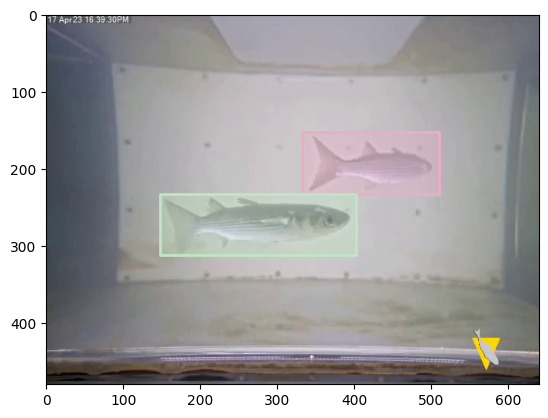

In [10]:
imgIds, annIds = plot_single_image(i_class=2, idx=2)

In [11]:
coco.loadAnns(annIds)

[{'id': 111,
  'image_id': 2097,
  'category_id': 2,
  'segmentation': [],
  'area': 14539.187599999996,
  'bbox': [331.92, 151.33, 178.22, 81.58],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}},
 {'id': 112,
  'image_id': 2097,
  'category_id': 2,
  'segmentation': [],
  'area': 20403.2,
  'bbox': [147.37, 232.12, 255.04, 80.0],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}}]

In [12]:
# check if attrs(iscrowd, occluded, rotation) are available info.
for i in range(C.NUM_CLASS):
    annIds = coco.getAnnIds(catIds=i)
    print(f"class {i}", len(annIds))
    for annId in annIds: 
        ann = coco.loadAnns(annId)
        annot_info = ann[0]

        iscrowd = annot_info['iscrowd']
        occluded = annot_info['attributes']['occluded']
        rotation = annot_info['attributes']['rotation']

        if iscrowd:
            print(iscrowd)
        if occluded:
            print(occluded)
        if rotation:
            print(rotation)


class 0 180
class 1 2344
class 2 651
class 3 2132
class 4 101
class 5 159
class 6 148
class 7 586


In [13]:
ann

[{'id': 8627,
  'image_id': 140238,
  'category_id': 7,
  'segmentation': [],
  'area': 36558.70939999999,
  'bbox': [82.27, 261.56, 287.66, 127.09],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}}]

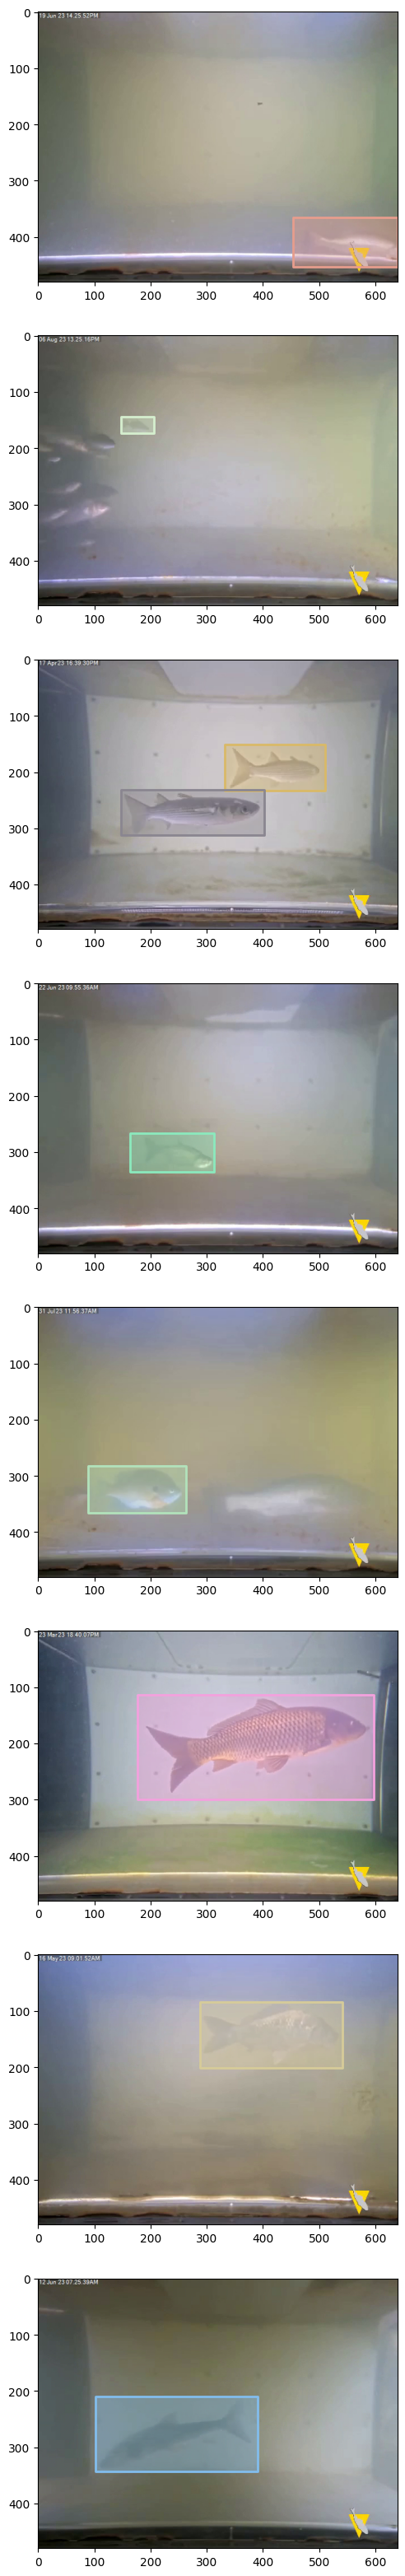

In [14]:
plot_multiple_images(idx=2)

## Analysis of Image-level information

1. num annots per image
2. average area per image
3. image pixel-level info, e.g., brightness or entropy
4. if 'k' class instance does exist

### 1. Num annots per image

평균: 0.06008104886769964
중앙값: 0.0
최댓값: 8
최솟값: 0
-inf, 0.0 	 사이 카운팅: 99314
0.0, 1.0 	 사이 카운팅: 5050
1.0, 2.0 	 사이 카운팅: 379
2.0, 3.0 	 사이 카운팅: 78
3.0, 4.0 	 사이 카운팅: 27
4.0, 5.0 	 사이 카운팅: 18
5.0, 6.0 	 사이 카운팅: 4
6.0, 7.0 	 사이 카운팅: 3
7.0, 8.0 	 사이 카운팅: 2
8.0, 9.0 	 사이 카운팅: 0


/tmp/ipykernel_77646/2002933915.py:27: RuntimeWarning: divide by zero encountered in log
  log_hist = np.log(hist)


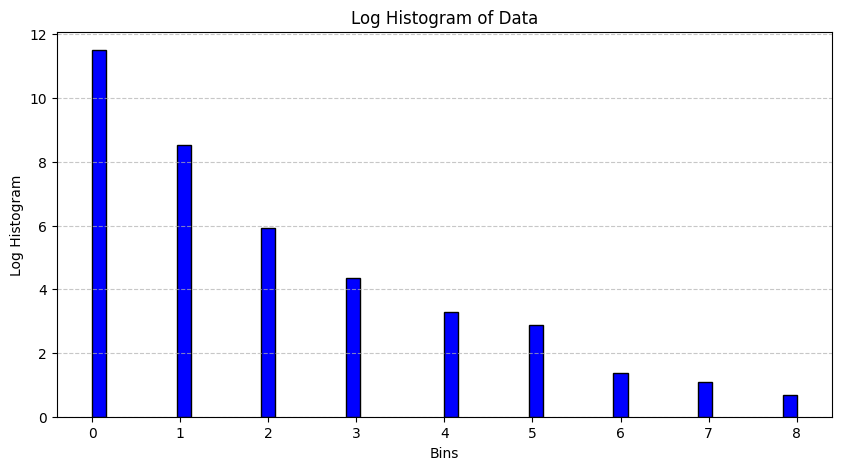

In [15]:
img_ids = coco.getImgIds()
list_num_annot = list()
for id in img_ids:
    list_num_annot.append(len(coco.getAnnIds(imgIds = [id])))

mean = np.mean(list_num_annot)
median = np.median(list_num_annot)
max_value = np.max(list_num_annot)
min_value = np.min(list_num_annot)

print(f"평균: {mean}")
print(f"중앙값: {median}")
print(f"최댓값: {max_value}")
print(f"최솟값: {min_value}")
np_range = np.arange(0, 10, 1)
bef = -np.inf
for i in np_range:
    print(f"{bef:.1f}, {i:.1f} \t 사이 카운팅: {sum(1 for num in list_num_annot if num <= i and num > bef)}")
    bef = i

# plt.hist(list_num_annot, bins=30)

# 히스토그램 계산
hist, bins = np.histogram(list_num_annot, bins=50)

# 로그를 적용하여 히스토그램 값 변환
log_hist = np.log(hist)

# 로그를 적용한 히스토그램 그래프 그리기
plt.figure(figsize=(10, 5))
plt.bar(bins[:-1], log_hist, width=np.diff(bins), align='edge', color='blue', edgecolor='black')
plt.xlabel('Bins')
plt.ylabel('Log Histogram')
plt.title('Log Histogram of Data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 0 vs. the else
## 3 이상 vs. the else
## 5 이상 vs. the else

### 2. Average area of instances per image

평균: 1203.6482606190466
중앙값: 0.0
최댓값: 151957.6744
최솟값: 0.0
-inf, 0.0 	 사이 카운팅: 99314
0.0, 5000.0 	 사이 카운팅: 69
5000.0, 10000.0 	 사이 카운팅: 931
10000.0, 15000.0 	 사이 카운팅: 1156
15000.0, 20000.0 	 사이 카운팅: 898
20000.0, 25000.0 	 사이 카운팅: 678
25000.0, 30000.0 	 사이 카운팅: 508
30000.0, 35000.0 	 사이 카운팅: 407
35000.0, 40000.0 	 사이 카운팅: 268
40000.0, 45000.0 	 사이 카운팅: 192
45000.0, 50000.0 	 사이 카운팅: 120
50000.0, 55000.0 	 사이 카운팅: 83
55000.0, 60000.0 	 사이 카운팅: 60
60000.0, 65000.0 	 사이 카운팅: 51
65000.0, 70000.0 	 사이 카운팅: 34
70000.0, 75000.0 	 사이 카운팅: 26
75000.0, 80000.0 	 사이 카운팅: 20
80000.0, 85000.0 	 사이 카운팅: 14
85000.0, 90000.0 	 사이 카운팅: 14
90000.0, 95000.0 	 사이 카운팅: 6
The most frequent bin: 9257.671849999999


/tmp/ipykernel_77646/3080275176.py:41: RuntimeWarning: divide by zero encountered in log
  log_hist = np.log(hist)


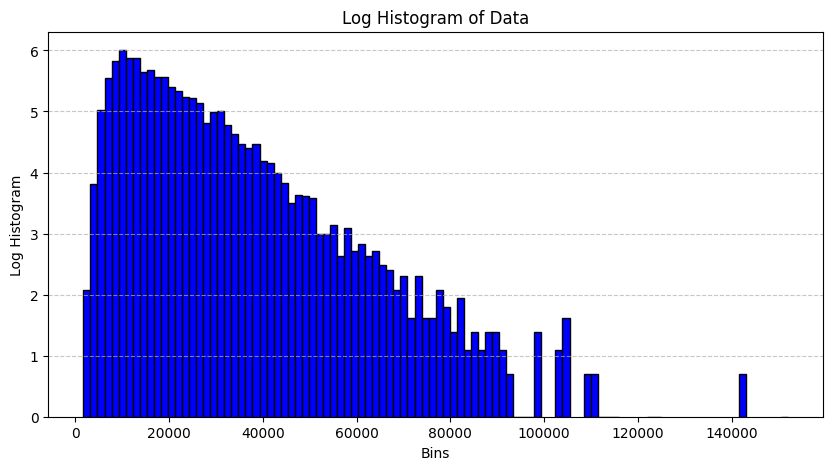

In [16]:
img_ids = coco.getImgIds()
list_area = list()
for id in img_ids:
    annIds = coco.getAnnIds(imgIds = [id])
    _area = list()
    for annId in annIds:
        ann = coco.loadAnns(annId)[0]
        _area.append(ann['area'])
    if len(_area) == 0 :
        list_area.append(0)
    else:
        list_area.append(np.mean(_area))

mean = np.mean(list_area)
median = np.median(list_area)
max_value = np.max(list_area)
min_value = np.min(list_area)

print(f"평균: {mean}")
print(f"중앙값: {median}")
print(f"최댓값: {max_value}")
print(f"최솟값: {min_value}")

np_range = np.arange(0, 100000, 5000)
bef = -np.inf
for i in np_range:
    print(f"{bef:.1f}, {i:.1f} \t 사이 카운팅: {sum(1 for num in list_area if num <= i and num > bef)}")
    bef = i

# Remove all occurrences of the value from the list
list_area_wo_zero = list()
for i in list_area:
    if i > 0:
        list_area_wo_zero.append(i)

# 히스토그램 계산
hist, bins = np.histogram(list_area_wo_zero, bins=100)


# 로그를 적용하여 히스토그램 값 변환
log_hist = np.log(hist)
most_frequent_bin = bins[np.argmax(hist)]
print(f"The most frequent bin: {most_frequent_bin}")

# 로그를 적용한 히스토그램 그래프 그리기
plt.figure(figsize=(10, 5))
plt.bar(bins[:-1], log_hist, width=np.diff(bins), align='edge', color='blue', edgecolor='black')
plt.xlabel('Bins')
plt.ylabel('Log Histogram')
plt.title('Log Histogram of Data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 0 vs. the else
## 9000 이상 vs. the else
## 80000 이상 vs. the else

### 3. Image Entropy

In [17]:
# img_ids = coco.getImgIds()
# list_img_ids = list()
# list_entropy = list()
# for id in tqdm(img_ids):
#     list_img_ids.append(id)
#     imgInfo = coco.loadImgs(id)

#     image = np.array(Image.open(os.path.join(str(C.DATA_ROOT_PATH_TRAIN), imgInfo[0]['file_name'])\
#                        ).convert('RGB'))
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     histogram = np.histogram(gray_image, bins=256, range=(0, 256))[0]
#     pixel_probabilities = histogram / float(np.sum(histogram))
#     entropy = -np.sum(pixel_probabilities * np.log2(pixel_probabilities + 1e-9))  # 1e-9를 더해 안전성을 높임
#     list_entropy.append(entropy)

# with open('image_ids.txt', 'w') as file:
#     for item in list_img_ids:
#         file.write(str(item) + '\n')

# with open('image_entropy.txt', 'w') as file:
#     for item in list_entropy:
#         file.write(str(item) + '\n')

In [18]:
## load saved entropy list

with open('image_ids.txt', 'r') as file:
    lines = file.readlines()
list_img_ids = [float(line.strip()) for line in lines]

with open('image_entropy.txt', 'r') as file:
    lines = file.readlines()
list_entropy = [float(line.strip()) for line in lines]

평균: 6.76947339109271
중앙값: 6.8020171554538535
최댓값: 7.769346319956593
최솟값: 0.13447574063278256
-inf, 5.0 	 사이 카운팅: 562
5.0, 5.2 	 사이 카운팅: 18
5.2, 5.4 	 사이 카운팅: 53
5.4, 5.6 	 사이 카운팅: 26
5.6, 5.8 	 사이 카운팅: 236
5.8, 6.0 	 사이 카운팅: 367
6.0, 6.2 	 사이 카운팅: 843
6.2, 6.4 	 사이 카운팅: 4853
6.4, 6.6 	 사이 카운팅: 18902
6.6, 6.8 	 사이 카운팅: 26284
6.8, 7.0 	 사이 카운팅: 28768
7.0, 7.2 	 사이 카운팅: 16336
7.2, 7.4 	 사이 카운팅: 6382
7.4, 7.6 	 사이 카운팅: 1146
7.6, 7.8 	 사이 카운팅: 99


(array([1.7800e+02, 5.0000e+00, 5.0000e+00, 3.0000e+00, 2.0000e+00,
        3.0000e+00, 8.0000e+00, 6.0000e+00, 7.0000e+00, 4.0000e+00,
        7.0000e+00, 6.0000e+00, 1.4000e+01, 1.3000e+01, 1.5000e+01,
        1.3000e+01, 1.1000e+01, 7.0000e+00, 5.0000e+00, 8.0000e+00,
        8.0000e+00, 1.0000e+01, 6.0000e+00, 2.0000e+00, 5.0000e+00,
        1.0000e+01, 6.0000e+00, 8.0000e+00, 6.0000e+00, 1.2000e+01,
        5.0000e+00, 5.0000e+00, 8.0000e+00, 6.0000e+00, 6.0000e+00,
        9.0000e+00, 5.0000e+00, 3.0000e+00, 3.0000e+00, 8.0000e+00,
        6.0000e+00, 1.0000e+00, 6.0000e+00, 6.0000e+00, 2.0000e+00,
        1.2000e+01, 8.0000e+00, 6.0000e+00, 7.0000e+00, 6.0000e+00,
        3.0000e+00, 9.0000e+00, 2.0000e+00, 3.0000e+00, 7.0000e+00,
        4.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00,
        3.0000e+00, 6.0000e+00, 5.0000e+00, 3.0000e+00, 7.0000e+00,
        8.0000e+00, 9.0000e+00, 4.1000e+01, 5.0000e+00, 9.0000e+00,
        1.6000e+01, 4.0000e+00, 7.2000e+01, 1.22

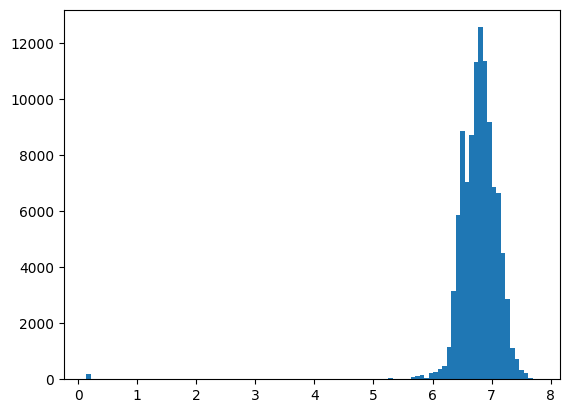

In [19]:
mean = np.mean(list_entropy)
median = np.median(list_entropy)
max_value = np.max(list_entropy)
min_value = np.min(list_entropy)

print(f"평균: {mean}")
print(f"중앙값: {median}")
print(f"최댓값: {max_value}")
print(f"최솟값: {min_value}")

np_range = np.arange(5, 8, 0.2)
bef = -np.inf
for i in np_range:
    print(f"{bef:.1f}, {i:.1f} \t 사이 카운팅: {sum(1 for num in list_entropy if num <= i and num > bef)}")
    bef = i
plt.hist(list_entropy, bins=100)

# 6이하 vs. the else
# 7.2이상 vs. the else

### 4. if 'k' class instance does exist

In [20]:
img_ids = coco.getImgIds()

list_class_info = [[] for _ in range(C.NUM_CLASS)]
for id in img_ids:
    annIds = coco.getAnnIds(imgIds = [id])

    _cat = list()
    for annId in annIds:
        ann = coco.loadAnns(annId)[0]
        _cat.append(ann['category_id'])
    
    for i_class in range(C.NUM_CLASS):
        if i_class in _cat :
            list_class_info[i_class].append(1)
        else:
            list_class_info[i_class].append(0)


## Fold Split

In [21]:
img_ids = coco.getImgIds()

df = pd.DataFrame({
    'img_id': img_ids, 
    'num_annot': list_num_annot, 
    'average_area': list_area, 
    'entropy': list_entropy,
    'is_class_0': list_class_info[0],
    'is_class_1': list_class_info[1],
    'is_class_2': list_class_info[2],
    'is_class_3': list_class_info[3],
    'is_class_4': list_class_info[4],
    'is_class_5': list_class_info[5],
    'is_class_6': list_class_info[6],
    'is_class_7': list_class_info[7],
})

In [22]:
df_fold = df.copy()

In [23]:
df_fold['stratify_num_annot_1'] = df["num_annot"].apply(lambda x: int(x == 0.0))
df_fold['stratify_num_annot_2'] = df["num_annot"].apply(lambda x: int(x >= 3.0))
df_fold['stratify_num_annot_3'] = df["num_annot"].apply(lambda x: int(x >= 5.0))

In [24]:
df_fold['stratify_average_area_1'] = df["average_area"].apply(lambda x: int(x == 0.0))
df_fold['stratify_average_area_2'] = df["average_area"].apply(lambda x: int(x >= 9000.0))
df_fold['stratify_average_area_3'] = df["average_area"].apply(lambda x: int(x >= 80000.0))

In [25]:
df_fold['stratify_entropy_1'] = df["entropy"].apply(lambda x: int(x == 0.0))
df_fold['stratify_entropy_2'] = df["entropy"].apply(lambda x: int(x <= 6.0))
df_fold['stratify_entropy_3'] = df["entropy"].apply(lambda x: int(x >= 7.2))

In [26]:
for i in range(C.NUM_CLASS):
    df_fold[f'stratify_is_class_{i}'] = df[f"is_class_{i}"].apply(lambda x: int(x == 1.0))

In [38]:
def _merge_features(series: pd.Series, strat_features: list):
    """ Merge features with underscore into single column. """
    values = []
    for feat in strat_features:
        if feat + "_bin" in series.index:
            feat = feat + "_bin"
        values.append(str(series[feat]))
    return "_".join(values)


def split_features(
    df: pd.DataFrame,
    strat_features: list,
    n_splits: int = 10,
    random_state: int = 1,
    shuffle: bool = True,
) -> Tuple[dict, pd.DataFrame]:
    """ Split input df, stratifying `strat_features` """
    df["fold"] = -1
    df["stratify"] = df.apply(partial(_merge_features, strat_features=strat_features), axis=1)

    X = df.copy()
    y = df["stratify"].copy()

    skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    # fold dictionaries containing N folds, each element being tuple of (train, test) dataframes
    for fold_num, (train_index, test_index) in enumerate(skf.split(X, y)):
        df.loc[test_index, "fold"] = fold_num  # starts from 1

    return df

In [39]:
stratify_features = list()
for i_key in df_fold.keys():
    if "stratify_" in i_key:
        stratify_features.append(i_key)
df_fold_added = split_features(df_fold, stratify_features, n_splits=C.NUM_FOLD, random_state=1)
df_fold_added["fold"].value_counts().sort_index()

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


fold
0    10488
1    10488
2    10488
3    10488
4    10488
5    10487
6    10487
7    10487
8    10487
9    10487
Name: count, dtype: int64

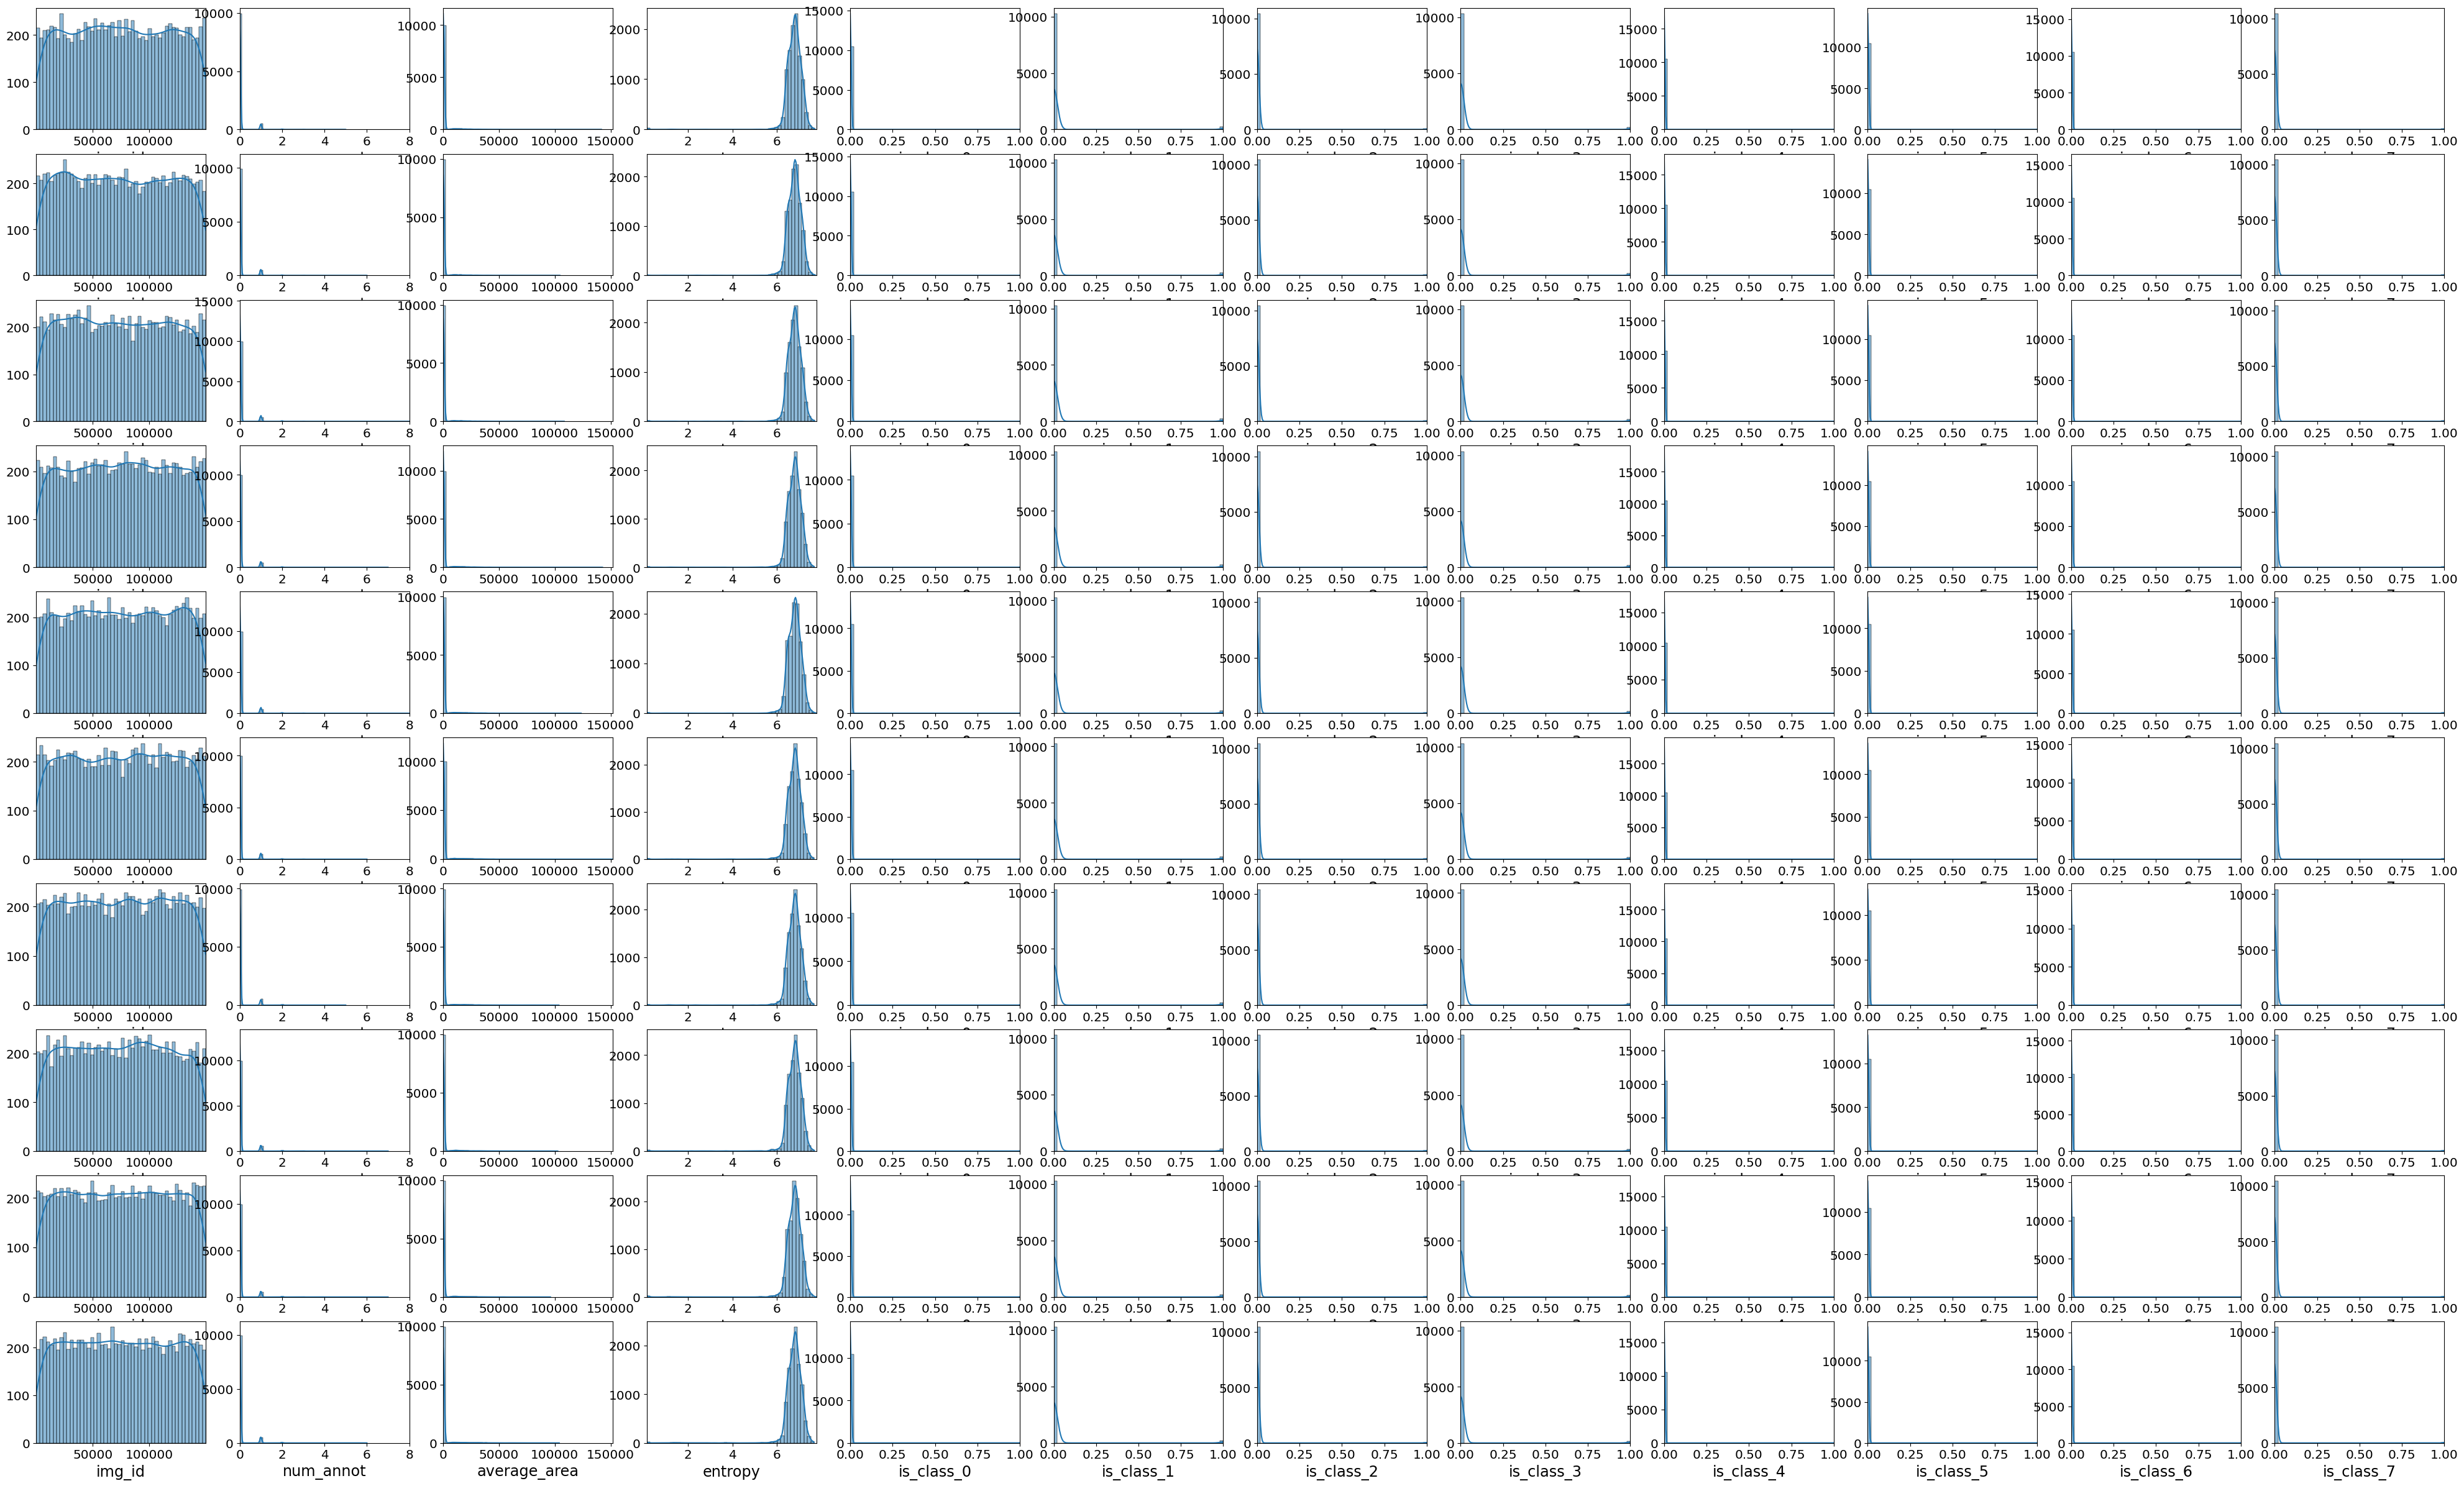

In [40]:
num_fold = C.NUM_FOLD
fig, axes = plt.subplots(nrows=num_fold, ncols=len(C.IMAGE_FEATURES), figsize=(50, 30))
for i_fold in range(num_fold):
    for idx, field in enumerate(C.IMAGE_FEATURES):
        sns.histplot(x=field, data=df_fold_added[df_fold_added["fold"] == i_fold].sort_values(by=field), kde=True, bins=50, ax=axes[i_fold, idx])
        axes[i_fold, idx].set_xlim(df_fold_added[field].min(), df_fold_added[field].max())
        axes[i_fold, idx].set_xlabel(field, size="xx-large")
        axes[i_fold, idx].set_ylabel("")
        axes[i_fold, idx].tick_params(axis="both", labelsize="x-large")

In [57]:
# Check the num of label across the fold index
for i_class in range(C.NUM_CLASS):
    print('-' * 100)
    print("class", i_class)
    print('-' * 100)
    for i_fold in range(C.NUM_FOLD):
        print("fold", i_fold)
        print(df_fold_added[df_fold_added['fold']==i_fold][f'is_class_{i_class}'].value_counts()[1])

----------------------------------------------------------------------------------------------------
class 0
----------------------------------------------------------------------------------------------------
fold 0
14
fold 1
14
fold 2
15
fold 3
17
fold 4
16
fold 5
16
fold 6
17
fold 7
16
fold 8
15
fold 9
16
----------------------------------------------------------------------------------------------------
class 1
----------------------------------------------------------------------------------------------------
fold 0
224
fold 1
223
fold 2
224
fold 3
225
fold 4
225
fold 5
226
fold 6
225
fold 7
223
fold 8
224
fold 9
224
----------------------------------------------------------------------------------------------------
class 2
----------------------------------------------------------------------------------------------------
fold 0
56
fold 1
57
fold 2
54
fold 3
54
fold 4
54
fold 5
55
fold 6
53
fold 7
53
fold 8
53
fold 9
55
------------------------------------------------------------

In [41]:
df_fold_added.to_csv('image_info.csv', index=False)

In [66]:
# check dimension of the given images
for idx, row in tqdm(df_fold_added.iterrows(), total=len(df_fold_added)):
    imgIds = row['img_id']
    imgInfo = coco.loadImgs(imgIds)
    shape = np.array(Image.open(os.path.join(str(C.DATA_ROOT_PATH_TRAIN), imgInfo[0]['file_name'])\
                        ).convert('RGB')).shape
    if (480, 640, 3) != shape:
        print(shape)
    break

  0%|          | 0/104875 [00:00<?, ?it/s]
